In [2]:
import torch
from torch import nn
from PIL import Image

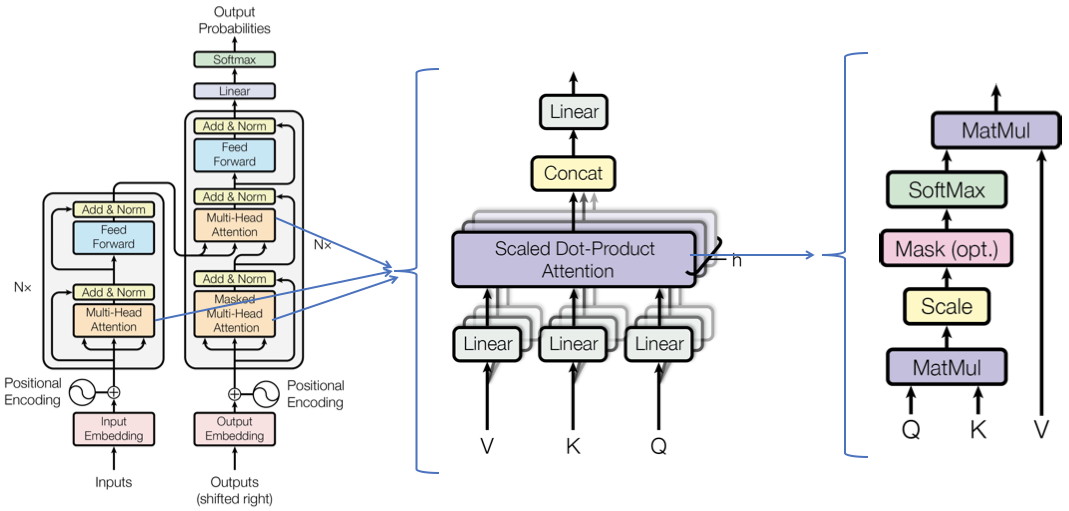

In [16]:
Image.open('./1_9nUzdaTbKzJrAsq1qqJNNA.png')

In [76]:
class Attention(nn.Module):
    def __init__(self, hidden_size, heads=8):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.heads = heads
        self.head_dim = hidden_size // heads
        self.fc = nn.Linear(hidden_size, hidden_size)
        assert (
            self.head_dim * heads == hidden_size
        ), "Hidden size must be divisible by heads"

    def forward(self, key, value, query, mask=None):
        N = query.shape[0]
        query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]
        query = torch.reshape(query, (N, query_len, self.heads, self.head_dim))
        key = torch.reshape(key, (N, key_len, self.heads, self.head_dim))
        value = torch.reshape(value, (N, value_len, self.heads, self.head_dim))
        matmul = torch.einsum("nqhd,nkhd->nhqk", [query, key])
        scale = matmul / (self.hidden_size ** (1 / 2))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(scale, dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, value]).reshape(
            N, query_len, self.hidden_size
        )
        out = self.fc(out)
        return out


class Transformer(nn.Module):
    def __init__(self, hidden_size, heads, dropout, forward_expansion):
        super(Transformer, self).__init__()
        self.attention = Attention(hidden_size, heads)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, forward_expansion * hidden_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * hidden_size, hidden_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, key, value, query, mask=None):
        attention = self.attention(key, value, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [85]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.layers = nn.ModuleList(
            Transformer(embed_size, heads, dropout, forward_expansion)
            for _ in range(num_layers)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        for layer in self.layers:
            out = layer(out, out, out, mask)
        return out


class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = Attention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer = Transformer(embed_size, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, tgt_mask):
        attention = self.attention(x, x, x, tgt_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer(key, value, query, src_mask)
        return out


class Decoder(nn.Module):
    def __init__(
        self,
        tgt_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.layers = nn.ModuleList(
            DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
            for _ in range(num_layers)
        )
        self.fc_out = nn.Linear(embed_size, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, tgt_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, tgt_mask)
        out = self.fc_out(x)
        return out

In [89]:
model = Encoder(100,512,6,8,torch.device('cpu'),4,0.1,100)

In [91]:
x = torch.rand(64,100).long()
model(x,None).shape

torch.Size([64, 100, 512])

In [2]:
from torch import nn

import torch

In [3]:
from timm.models.layers.helpers import to_2tuple
from timm.models.layers import DropPath, trunc_normal_



In [90]:
class PatchEmbed(nn.Module):
    """
    Patch Embedding that is implemented by a layer of conv.
    Input: tensor in shape [B, C, H, W]
    Output: tensor in shape [B, C, H/stride, W/stride]
    """

    def __init__(
        self, patch_size, stride,in_channels, embed_dim, padding=0, norm_layer=None
    ):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        stride = to_2tuple(stride)
        padding = to_2tuple(padding)
        self.proj = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=stride, padding=padding
        )
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):

        x = self.proj(x)
        x = self.norm(x)
        return x


class LayerNormChannel(nn.Module):
    """
    LayerNorm only for Channel Dimension.
    Input: tensor in shape [B, C, H, W]
    """

    def __init__(self, num_channels, eps=1e-05):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight.unsqueeze(-1).unsqueeze(-1) * x + self.bias.unsqueeze(
            -1
        ).unsqueeze(-1)
        return x


class Mlp(nn.Module):
    """
    Implementation of MLP with 1*1 convolutions.
    Input: tensor with shape [B, C, H, W]
    """

    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Pooling(nn.Module):
    def __init__(self, pool_size=3):
        super(Pooling, self).__init__()
        self.pool = nn.AvgPool2d(
            pool_size, stride=1, padding=pool_size // 2, count_include_pad=False
        )

    def forward(self, x):
        return self.pool(x) - x

In [91]:
class PoolFormerBlock(nn.Module):
    def __init__(
        self,hidden_size
    ):
        super(PoolFormerBlock, self).__init__()
        self.norm1 = LayerNormChannel(hidden_size)
        self.norm2 = LayerNormChannel(hidden_size)
        self.MLP = nn.ModuleList(Mlp(hidden_size) for _ in range(4))
        self.polling = Pooling()

    def forward(self, x):
        x_origin = x
        x = self.norm1(x)
        x = self.polling(x)
        x_1 = x + x_origin
        x = self.norm2(x_1)
        for mlp in self.MLP:
            out = mlp(x)
        out = out + x_1

        return out

In [92]:
patch_embed_small = [[7,4,64],[3,2,128],[3,2,320],[3,2,512]]
class SmallPoolFomer(nn.Module):
    def __init__(self):
        super(SmallPoolFomer, self).__init__()
        self.stage1 = nn.Sequential(
            PatchEmbed(patch_embed_small[0][0], patch_embed_small[0][1], 3, patch_embed_small[0][2]),
            PoolFormerBlock(patch_embed_small[0][2])
        )
        self.stage2 = nn.Sequential(
            PatchEmbed(patch_embed_small[1][0], patch_embed_small[1][1],patch_embed_small[0][2], patch_embed_small[1][2]),
            PoolFormerBlock(patch_embed_small[1][2])
        )
        self.stage3 = nn.Sequential(
            PatchEmbed(patch_embed_small[2][0], patch_embed_small[2][1],patch_embed_small[1][2], patch_embed_small[2][2]),
            PoolFormerBlock(patch_embed_small[2][2])
        )
        self.stage4 = nn.Sequential(
            PatchEmbed(patch_embed_small[3][0], patch_embed_small[3][1],patch_embed_small[2][2], patch_embed_small[3][2]),
            PoolFormerBlock(patch_embed_small[3][2])
        )

    def forward(self, x):
        
        x = self.stage1(x)
        print(x.shape)
        x = self.stage2(x)  
        x = self.stage3(x)
        return x

In [94]:
model = SmallPoolFomer()
model(torch.rand(1,3,224,224)).shape   

torch.Size([1, 64, 55, 55])


torch.Size([1, 320, 13, 13])